# Putting it all together: a case study

## Finch beaks and the need for statistics


### EDA of beak depths of Darwin's finches

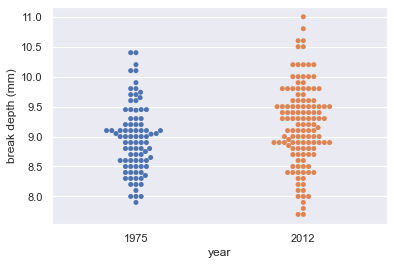

In [4]:
# from urllib.request import urlretrieve
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# url = "https://assets.datacamp.com/production/repositories/470/datasets/eb228490f7d823bfa6458b93db075ca5ccd3ec3d/finch_beaks_1975.csv"
# data= urlretrieve(url, "1975.csv")
df_1975 = pd.read_csv("1975.csv")

# url = "https://assets.datacamp.com/production/repositories/470/datasets/b28d5bf65e38460dca7b3c5c0e4d53bdfc1eb905/finch_beaks_2012.csv"
# data= urlretrieve(url, "2012.csv")
df_2012 = pd.read_csv("2012.csv")

scandens_1975 = df_1975[df_1975["species"] == "scandens"].rename(columns = {"Beak depth, mm":"beak_depth"})
scandens_1975 = scandens_1975.drop(["band","species","Beak length, mm"], axis = 1)
scandens_1975 = scandens_1975.reset_index(drop=True)
scandens_1975["year"] = 1975
scandens_2012 = df_2012[df_2012["species"] == "scandens"].rename(columns = {"bdepth":"beak_depth"})
scandens_2012 = scandens_2012.drop(["band","species","blength"], axis = 1)
scandens_2012 = scandens_2012.reset_index(drop=True)
scandens_2012["year"] = 2012
df = scandens_1975.append(scandens_2012,ignore_index =True)

import seaborn as sns
sns.set()
sns.swarmplot(x="year", y="beak_depth",data=df)
plt.xlabel("year")
plt.ylabel("break depth (mm)")
plt.show()

It is kind of hard to see if there is a clear difference between the 1975 and 2012 data set. Eyeballing it, it appears as though the mean of the 2012 data set might be slightly higher, and it might have a bigger variance.

### ECDFs of beak depths

While bee swarm plots are useful, we found that ECDFs are often even better when doing EDA. 

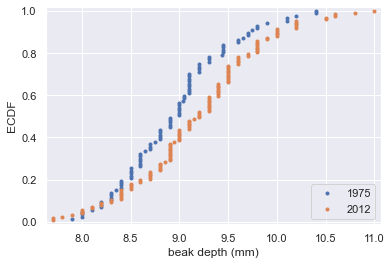

In [5]:
def ecdf(data):
    n = len(data)
    x = np.sort(data)
    y = np.arange(1, n+1) / n
    return x, y
bd_1975 = df[df["year"] == 1975]["beak_depth"]
bd_2012 = df[df["year"] == 2012]["beak_depth"]

x_1975, y_1975 = ecdf(bd_1975)
x_2012, y_2012 = ecdf(bd_2012)
plt.plot(x_1975, y_1975, marker=".", linestyle="none")
plt.plot(x_2012, y_2012, marker=".", linestyle="none")
plt.margins(0.02)
plt.xlabel("beak depth (mm)")
plt.ylabel("ECDF")
plt.legend(["1975", "2012"], loc="lower right")
plt.show()

The differences are much clearer in the ECDF. The mean is larger in the 2012 data, and the variance does appear larger as well.

### Parameter estimates of beak depths

Estimate the difference of the mean beak depth of the G. scandens samples from 1975 and 2012 and report a 95% confidence interval.

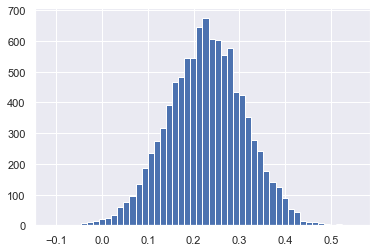

difference of means = 0.2262204724409429 mm
95% confidence interval = [0.0595972  0.39079786] mm


In [6]:
def bootstrap_replicate_1d(data, func):
    bs_sample = np.random.choice(data, len(data))
    return func(bs_sample)
def draw_bs_reps(data, func, size=1):
    bs_replicates = np.empty(size)
    for i in range(size):
        bs_replicates[i] = bootstrap_replicate_1d(data, func)
    return bs_replicates
mean_diff = np.mean(bd_2012) - np.mean(bd_1975)
bs_replicates_1975 = draw_bs_reps(bd_1975, np.mean, 10000)
bs_replicates_2012 = draw_bs_reps(bd_2012, np.mean, 10000)

bs_diff_replicates = bs_replicates_2012 - bs_replicates_1975
plt.hist(bs_diff_replicates, bins=50)
plt.show()
conf_int = np.percentile(bs_diff_replicates, [2.5, 97.5])
print('difference of means =', mean_diff, 'mm')
print('95% confidence interval =', conf_int, 'mm')

### Hypothesis test: Are beaks deeper in 2012?

Plot of the ECDF and determination of the confidence interval make it pretty clear that the beaks of G. scandens on Daphne Major have gotten deeper. But is it possible that this effect is just due to random chance? In other words, what is the probability that we would get the observed difference in mean beak depth if the means were the same?

But the hypothesis we are testing is not that the beak depths come from the same distribution. For that the permutation test could be used. The hypothesis is that the means are equal. To perform this hypothesis test, we need to shift the two data sets so that they have the same mean and then use bootstrap sampling to compute the difference of means.

In [7]:
combined_mean = np.mean(np.concatenate((bd_1975, bd_2012)))
bd_1975_shifted = bd_1975 - np.mean(bd_1975) + combined_mean
bd_2012_shifted = bd_2012 - np.mean(bd_2012) + combined_mean

bs_replicates_1975 = draw_bs_reps(bd_1975_shifted, np.mean, 10000)
bs_replicates_2012 = draw_bs_reps(bd_2012_shifted, np.mean, 10000)

bs_diff_replicates = bs_replicates_2012 - bs_replicates_1975
p = np.sum(bs_diff_replicates >= mean_diff) / len(bs_diff_replicates)
print("p =", p)

p = 0.0043


We get a p-value of 0.0034, which suggests that there is a statistically significant difference. But remember: it is very important to know how different they are! In the previous exercise, you got a difference of 0.2 mm between the means. You should combine this with the statistical significance. Changing by 0.2 mm in 37 years is substantial by evolutionary standards. If it kept changing at that rate, the beak depth would double in only 400 years.

## Variation in beak shapes

### EDA of beak length and depth

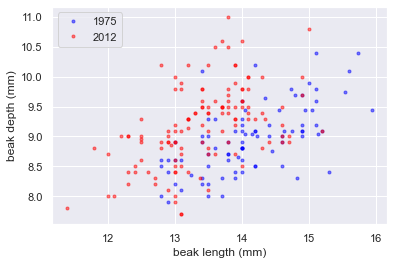

In [8]:
bl_1975 = np.array(df_1975[df_1975["species"] == "scandens"]["Beak length, mm"])
bl_2012 = np.array(df_2012[df_2012["species"] == "scandens"]["blength"])

plt.plot(bl_1975, bd_1975, marker=".", linestyle="none", color="blue", alpha=0.5)
plt.plot(bl_2012, bd_2012, marker=".", linestyle="none", color="red", alpha=0.5)
plt.xlabel("beak length (mm)")
plt.ylabel("beak depth (mm)")
plt.legend(('1975', '2012'), loc='upper left')
plt.show()

Beaks got deeper (the red points are higher up in the y-direction), but not really longer. If anything, they got a bit shorter, since the red dots are to the left of the blue dots. So, it does not look like the beaks kept the same shape; they became shorter and deeper.

### Linear regressions

Perform a linear regression for both the 1975 and 2012 data.

In [9]:
np.random.seed(42)
bd_1975 = np.array(bd_1975)
bd_2012 = np.array(bd_2012)
def draw_bs_pairs_linreg(x, y, size=1):
    inds = np.arange(0, len(x))
    bs_slope_reps = np.empty(size)
    bs_intercept_reps = np.empty(size)
    for i in range(size):
        bs_inds = np.random.choice(inds, size=len(inds))
        bs_x, bs_y = x[bs_inds], y[bs_inds]
        bs_slope_reps[i], bs_intercept_reps[i] = np.polyfit(bs_x, bs_y, 1)
    return bs_slope_reps, bs_intercept_reps

slope_1975, intercept_1975 = np.polyfit(bl_1975, bd_1975, 1)
slope_2012, intercept_2012 = np.polyfit(bl_2012, bd_2012, 1)

bs_slope_reps_1975, bs_intercept_reps_1975 = draw_bs_pairs_linreg(bl_1975, bd_1975, 1000)
bs_slope_reps_2012, bs_intercept_reps_2012 = draw_bs_pairs_linreg(bl_2012, bd_2012, 1000)

slope_conf_int_1975 = np.percentile(bs_slope_reps_1975, [2.5, 97.5])
intercept_conf_int_1975 = np.percentile(bs_intercept_reps_1975, [2.5, 97.5])
slope_conf_int_2012 = np.percentile(bs_slope_reps_2012, [2.5, 97.5])
intercept_conf_int_2012 = np.percentile(bs_intercept_reps_2012, [2.5, 97.5])

print("1975: slope =", slope_1975,
     "conf int =", slope_conf_int_1975)
print("1975: intercept =", intercept_1975,
     "conf int =", intercept_conf_int_1975)
print("2012: slope =", slope_2012,
     "conf int =", slope_conf_int_2012)
print("2012: intercept =", intercept_2012,
     "conf int =", intercept_conf_int_2012)

1975: slope = 0.4652051691605937 conf int = [0.33851226 0.59306491]
1975: intercept = 2.3908752365842263 conf int = [0.64892945 4.18037063]
2012: slope = 0.462630358835313 conf int = [0.33137479 0.60695527]
2012: intercept = 2.9772474982360198 conf int = [1.06792753 4.70599387]


 It looks like they have the same slope, but different intercepts.

### Displaying the linear regression results

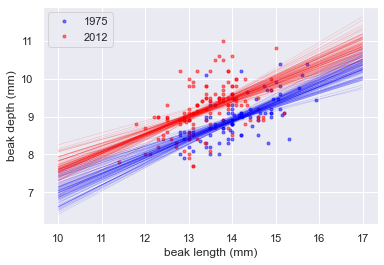

In [10]:
plt.plot(bl_1975, bd_1975, marker=".", linestyle="none", color="blue", alpha=0.5)
plt.plot(bl_2012, bd_2012, marker=".", linestyle="none", color="red", alpha=0.5)
plt.xlabel("beak length (mm)")
plt.ylabel("beak depth (mm)")
plt.legend(("1975", "2012"), loc="upper left")
x = np.array([10, 17])
for i in range(100):
    plt.plot(x, x * bs_slope_reps_1975[i] + bs_intercept_reps_1975[i], linewidth=0.5, color="blue", alpha=0.2)
    plt.plot(x, x * bs_slope_reps_2012[i] + bs_intercept_reps_2012[i], linewidth=0.5, color="red", alpha=0.2)
plt.show()

### Beak length to depth ratio


The linear regressions showed interesting information about the beak geometry. The slope was the same in 1975 and 2012, suggesting that for every millimeter gained in beak length, the birds gained about half a millimeter in depth in both years. However, if we are interested in the shape of the beak, we want to compare the ratio of beak length to beak depth. Let's make that comparison.

In [11]:
ratio_1975 = bl_1975 / bd_1975
ratio_2012 = bl_2012 / bd_2012

mean_ratio_1975 = np.mean(ratio_1975)
mean_ratio_2012 = np.mean(ratio_2012)

bs_replicates_1975 = draw_bs_reps(ratio_1975, np.mean, 10000)
bs_replicates_2012 = draw_bs_reps(ratio_2012, np.mean, 10000)
conf_int_1975 = np.percentile(bs_replicates_1975, [0.5, 99.5])
conf_int_2012 = np.percentile(bs_replicates_2012, [0.5, 99.5])

print('1975: mean ratio =', mean_ratio_1975, 'conf int =', conf_int_1975)
print('2012: mean ratio =', mean_ratio_2012, 'conf int =', conf_int_2012)



1975: mean ratio = 1.5788823771858533 conf int = [1.55633932 1.60104148]
2012: mean ratio = 1.4658342276847767 conf int = [1.44405887 1.48750665]


### How different is the ratio?

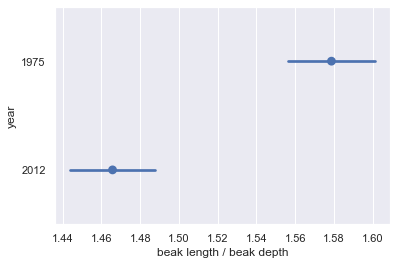

In [13]:
a = {"conf": list(conf_int_1975)+ list(conf_int_2012), "year":[1975,1975,2012,2012]}
a = pd.DataFrame(a)
a["year"] = a["year"].astype("category")
sns.pointplot( x="conf",y="year",data=a, join=False)
plt.xlabel("beak length / beak depth")
plt.show()

The mean beak length-to-depth ratio decreased by about 0.1, or 7%, from 1975 to 2012. The 99% confidence intervals are not even close to overlapping. 

But still it is impossible to say if this is a real effect or just due to noise without computing a p-value. 

# Calculation of heritability

### EDA of heritability

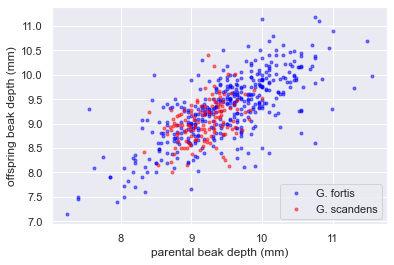

In [40]:
# url = "https://assets.datacamp.com/production/repositories/470/datasets/532cb2fecd1bffb006c79a28f344af2290d643f3/fortis_beak_depth_heredity.csv"
# data_fortis = urlretrieve(url, "parent_fortis.csv")
# url = "https://assets.datacamp.com/production/repositories/470/datasets/7ff772e1f4e99ed93685296063b6e604a334236d/scandens_beak_depth_heredity.csv"
# data_fortis = urlretrieve(url, "parent_scandens.csv")
parent_fortis = pd.read_csv("parent_fortis.csv")
parent_scandens = pd.read_csv("parent_scandens.csv")
bd_parent_fortis = np.array((parent_fortis["Male BD"] + parent_fortis["Female BD"]) /2 )
bd_offspring_fortis = np.array(parent_fortis["Mid-offspr"])

bd_parent_scandens = np.array(parent_scandens["mid_parent"])
bd_offspring_scandens = np.array(parent_scandens["mid_offspring"])

plt.plot(bd_parent_fortis, bd_offspring_fortis, marker=".", linestyle="none", color="blue",alpha=0.5)
plt.plot(bd_parent_scandens, bd_offspring_scandens, marker=".", linestyle="none", color="red",alpha=0.5)
plt.xlabel('parental beak depth (mm)')
plt.ylabel('offspring beak depth (mm)')
plt.legend(('G. fortis', 'G. scandens'), loc='lower right')
plt.show()

There is a stronger correlation in G. fortis than in G. scandens. This suggests that beak depth is more strongly inherited in G. fortis.

### Correlation of offspring and parental data

In [41]:
def draw_bs_pairs(x, y, func, size=1):
    inds = np.arange(len(x))
    bs_replicates = np.empty(size)
    for i in range(size):
        bs_inds = np.random.choice(inds, len(inds))
        bs_x, bs_y = x[bs_inds], y[bs_inds]
        bs_replicates[i] = func(bs_x, bs_y)
    return bs_replicates

### Pearson correlation of offspring and parental data

The Pearson correlation coefficient seems like a useful measure of how strongly the beak depth of parents are inherited by their offspring.

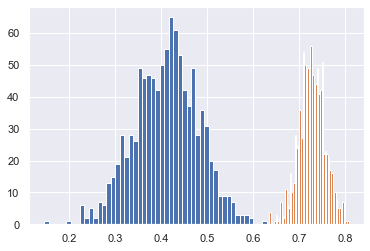

G. scandens: 0.4117063629401258 [0.2734338  0.54355609]
G. fortis: 0.7283412395518487 [0.66974819 0.78081364]


In [51]:
def pearson_r(x, y):
    corr_mat = np.corrcoef(x,y)
    return corr_mat[0,1]
r_scandens = pearson_r(bd_parent_scandens, bd_offspring_scandens)
r_fortis = pearson_r(bd_parent_fortis, bd_offspring_fortis)
bs_perlicates_scandens = draw_bs_pairs(bd_parent_scandens,bd_offspring_scandens,pearson_r, 1000)
bs_perlicates_fortis = draw_bs_pairs(bd_parent_fortis, bd_offspring_fortis,pearson_r, 1000)
conf_int_scandens = np.percentile(bs_perlicates_scandens, [2.5, 97.5])
conf_int_fortis = np.percentile(bs_perlicates_fortis, [2.5, 97.5])
plt.hist(bs_perlicates_scandens, bins=50)
plt.hist(bs_perlicates_fortis, bins=50)
plt.show()
print('G. scandens:', r_scandens, conf_int_scandens)
print('G. fortis:', r_fortis, conf_int_fortis)


It is clear from the confidence intervals that beak depth of the offspring of G. fortis parents is more strongly correlated with their offspring than their G. scandens counterparts.

### Measuring heritability

Pearson correlation coefficient is the ratio of the covariance to the geometric mean of the variances of the two data sets. This is a measure of the correlation between parents and offspring, but might not be the best estimate of heritability. 
It makes more sense to define heritability as the ratio of the covariance between parent and offspring to the variance of the parents alone. 


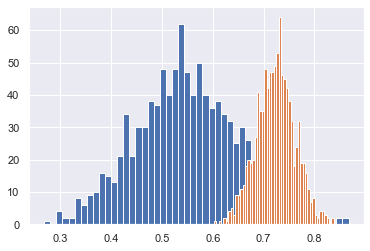

G. scandens: 0.5485340868685982 [0.35529834 0.7536438 ]
G. fortis: 0.7229051911438156 [0.64853914 0.79672518]


In [76]:
def heritability(parents, offspring):
    covariance_matrix = np.cov(parents, offspring)
    return covariance_matrix[0,1] / covariance_matrix[0,0]

heritability_scandens = heritability(bd_parent_scandens, bd_offspring_scandens)
heritability_fortis = heritability(bd_parent_fortis, bd_offspring_fortis)
replicates_scandens = draw_bs_pairs(bd_parent_scandens, bd_offspring_scandens,heritability, size=1000)
replicates_fortis = draw_bs_pairs(bd_parent_fortis, bd_offspring_fortis,heritability, size=1000)

conf_int_scandens = np.percentile(replicates_scandens,[2.5, 97.5])
conf_int_fortis = np.percentile(replicates_fortis,[2.5, 97.5])

plt.hist(replicates_scandens, bins=50)
plt.hist(replicates_fortis, bins=50)
plt.show()
print('G. scandens:', heritability_scandens, conf_int_scandens)
print('G. fortis:', heritability_fortis, conf_int_fortis)

G. fortis has stronger heritability than G. scandens. This suggests that the traits of G. fortis may be strongly incorporated into G. scandens by introgressive hybridization.



### Is beak depth heritable at all in G. scandens?

The heritability of beak depth in G. scandens seems low. It could be that this observed heritability was just achieved by chance and beak depth is actually not really heritable in the species. That hypothesis will be tested with pairs permutation test.

p-val = 0.0


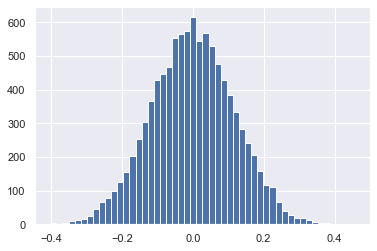

In [78]:
perm_replicates = np.empty(10000)
for i in range(10000):
    bd_parent_permuted = np.random.permutation(bd_parent_scandens)
    perm_replicates[i] = heritability(bd_parent_permuted, bd_offspring_scandens)

p = np.sum(perm_replicates >= heritability_scandens) / len(perm_replicates)
print('p-val =', p)
plt.hist(perm_replicates, bins=50)
plt.show()

p-value of zero, which means that none of the 10,000 permutation pairs replicates you drew had a heritability high enough to match that which was observed. This strongly suggests that beak depth is heritable in G. scandens, just not as much as in G. fortis. How extreme the value of heritability that is expected by chance can be seen from the plot.